# Imports

In [1]:
from sklearn.metrics import classification_report
import panel as pn 
import re

## Functions

In [2]:
from my_function import *
from plot_function import *

# Init Dataframe

In [3]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.05
sampl_fac = 1
num_data_points = 50

# Create empty Dataframe
df_cols = ['dataset', 'audio_file_name', 'pitch', 'onset_sec', 'amplitude', 'frequency']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [4]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
#path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC Chords/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac, num_data_points)
#df_ref.head(10)

Wall time: 314 ms


# Create Dataframe with testdatas

In [5]:
%%time
# paths testdata

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

for path in path_testdata:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac, num_data_points)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

Wall time: 7.93 s


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0005969542765022676, 0.001709201748739593, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.0034228128100198415, 0.004280687270656241, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0007040495234552155, 0.0016591744069152788,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.002487341671033241, 0.00492104988768014, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.0050438371645350035, 0.002266167192112708, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0024214063371930804, 0.0022118634395506833,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.0031924125558935325, 0.002750274986731964, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


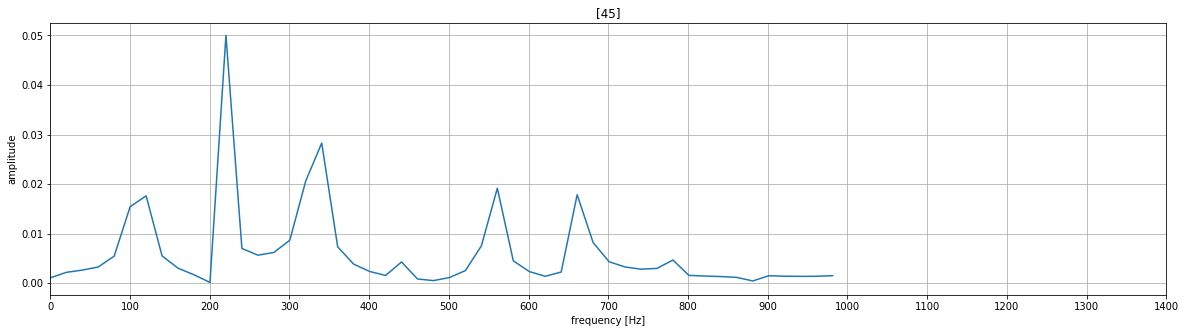

50

In [6]:
pitch = 6
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])

In [7]:
# drop duplicate in df_ref
df_ref_unique = pd.DataFrame(columns=df_cols)

for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique.head(10)

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.001709201748739593, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.004280687270656241, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.0016591744069152788,...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009527075804280047, 0.012250241045892342, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
6,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.004128384752338435, 0.002491926601108583, 0...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
7,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.002118874893707483, 0.0004992268356448352, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
8,dataset1/Fender Strat Clean Neck SC,G53-48108-1111-00009.wav,[48],0.2,"[0.004706986961451247, 0.0036225704564908073, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."
9,dataset1/Fender Strat Clean Neck SC,G53-49109-1111-00010.wav,[49],0.2,"[0.002570064484126984, 0.0007081923531536811, ...","[0.0, 20.02724795640327, 40.05449591280654, 60..."


## Histogram of Pitches Distribution

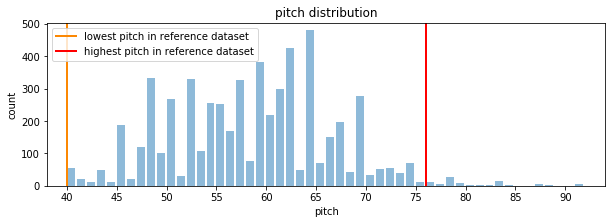

In [8]:
all_pitches_temp = df_test.pitch.tolist()

# flatten List
all_pitches = []
for sublist in all_pitches_temp:
    for item in sublist:
        all_pitches.append(item)

plot_hist(all_pitches, min(df_ref_unique.pitch), max(df_ref_unique.pitch), 10, 3)

In [9]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['target_vec'] = target_vec
df_test.head()

Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [80] muss innerhalb der Range(40 - 76)!
Pitch [81] muss innerhalb der Range(40 - 76)!
Pitch [82] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [84] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Range(40 - 76)!
Pitch [92] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Rang

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,target_vec
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.01021836468962585, 0.007419197032659204, 0....","[0.0, 20.02724795640327, 40.05449591280654, 60...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0005969542765022676, 0.001709201748739593, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.0034228128100198415, 0.004280687270656241, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0007040495234552155, 0.0016591744069152788,...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.0048971509176587305, 0.006496422462073519, ...","[0.0, 20.02724795640327, 40.05449591280654, 60...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Gurobi

In [10]:
# Build Model
m = Model('AMt')

lambs = []
bins = []
x = []
for lamb in range(len(df_ref_unique)):
    lambs.append(m.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
    bins.append(m.addVar(vtype = GRB.BINARY, name = 'bin_' + str(lamb)))
    #lambs.append(m.addVar(lb = 0, vtype = GRB.BINARY, name = 'lamb_' + str(lamb)))

amplitudes = df_test.amplitude.tolist()
len_amplitude = len(amplitudes[0])

for datapoint in range(len_amplitude):
    x.append(m.addVar(lb = 0, ub = 1, vtype = GRB.CONTINUOUS, name = 'x_' + str(datapoint)))
    
m.update()
m.printStats()

Using license file C:\Users\KennethSteiner\gurobi.lic
Academic license - for non-commercial use only

Statistics for model AMt :
  Linear constraint matrix    : 0 Constrs, 124 Vars, 0 NZs
  Variable types              : 87 Continuous, 37 Integer (37 Binary)
  Matrix coefficient range    : [ 0, 0 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 0, 0 ]


In [11]:
pred_vec = []
grb_time = 0
gamma = 0

len_lambs = len(lambs)
ref_notes = df_ref_unique.amplitude.tolist()
deviation = m.addVar(lb = -37, ub = 1, vtype = GRB.CONTINUOUS) # +1 Continuous

#Constraints
for i in range(len_lambs):
    m.addConstr(lambs[i] <= bins[i]) # +37 Constrs, + 2*37 NZs
    
m.addConstr(quicksum(bins) <= 6) # +1 Constrs, +37NZs
m.update()
m.printStats()


Statistics for model AMt :
  Linear constraint matrix    : 38 Constrs, 125 Vars, 111 NZs
  Variable types              : 88 Continuous, 37 Integer (37 Binary)
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 1, 37 ]
  RHS coefficient range       : [ 6, 6 ]


In [ ]:
%%time

for amplitude in amplitudes:
    cost_function = 0
    penalty = 0
    
    for sgn in range(len_amplitude):
        x[sgn].lb = x[sgn].ub = amplitude[sgn]
    
    for sgn in range(len_amplitude):
        approx_sgn = 0
        
        for i in range(len_lambs):
            approx_sgn += ref_notes[i][sgn] * lambs[i]
            #penalty += lambs[i] * lambs[i]
            #penalty += lambs[i]

        deviation = x[sgn] - approx_sgn
        cost_function += deviation * deviation
    
    #Params
    m.params.outputflag = 0 # Infotext ausblenden
    #m.params.Presolve = 0
    
    m.setObjective(cost_function + gamma * penalty, GRB.MINIMIZE)
    m.optimize()
    
    grb_time += m.Runtime
    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        if re.match(r'lamb', v.varName):
            approx_v.append(v.x)

    pred_vec.append(approx_v)

In [ ]:
#m.computeIIS()

In [ ]:
#m.computeIIS()
#print('\nThe following constraint cannot be satisfied:')
#for c in m.getConstrs():
#    if c.IISConstr:
#        print('%s' % c.constrName)
        # Remove a single constraint from the model
        #removed.append(str(c.constrName))
        #m.remove(c)

In [ ]:
#%%time
#pred_vec = []
#grb_time = 0
#gamma = 0
#
#len_lambs = len(lambs)
#amplitudes = df_test.amplitude.tolist()
#ref_notes = df_ref_unique.amplitude.tolist()
#
#for amplitude in amplitudes:
#    len_amplitude = len(amplitude)
#    deviation = 0
#    #deviation = m.addVar(lb = -37, ub = 1, vtype = GRB.CONTINUOUS)
#    cost_function = 0    
#    penalty = 0
#    
#    
#    for sgn in range(len_amplitude):
#        
#        approx_sgn = 0
#        for i in range(len_lambs):
#            approx_sgn += ref_notes[i][sgn] * lambs[i]
#            #penalty += lambs[i] * lambs[i]
#            #penalty += lambs[i]
#
#        deviation = amplitude[sgn] - approx_sgn
#        #m.addConstr(amplitude[sgn] - approx_sgn == deviation)
#        
#        #print(deviation)
#        cost_function += deviation * deviation
#    
#    #Params
#    m.params.outputflag = 0 # Infotext ausblenden
#    
#    #Constraints
#    for i in range(len_lambs):
#        m.addConstr(lambs[i] <= bins[i])
#    m.addConstr(quicksum(bins) <= 6)
#    
#    m.setObjective(cost_function + gamma * penalty, GRB.MINIMIZE)
#    m.optimize()
#    
#    grb_time += m.Runtime
#    approx_v = []
#
#    for v in m.getVars():
#        #print('%s: %g' % (v.varName, v.x))
#        if re.match(r'lamb', v.varName):
#            approx_v.append(v.x)
#
#    pred_vec.append(approx_v)

In [ ]:
df_test['pred_vec'] = pred_vec
df_test

# Calculate Pitch Score

In [ ]:
pitch_score = []

for vec in range(len(pred_vec)):
    pitch_score.append(metric(target_vec[vec], np.asarray(pred_vec[vec])))
    
df_test['pitch_score'] = pitch_score
df_test.head()

# Calculate F1 Score

In [ ]:
# normalize pred_vec
%time
norm_pred_vec = []

for j in range(len(df_test.pred_vec)):
    thresh_vec = []
    vec = norm_vec(df_test.pred_vec[j])
            
    norm_pred_vec.append(vec)

df_test['norm_pred_vec'] = norm_pred_vec
df_test.head()

In [ ]:
# get all max values from norm_pred_vec
max_val = []
for i in df_test.norm_pred_vec:
    max_val.append(np.amax(i))

In [ ]:
# thresholding vec_pred
#%time
thresholded_vec = []
pitch_pred = []
#threshold = max_val
threshold = 0.5

for j in range(len(df_test.norm_pred_vec)):
    thresh_vec = []
    vec = df_test.norm_pred_vec[j]
    
    for i in range(len(vec)):
        #if vec[i] >= threshold[j]:
        if vec[i] >= threshold:
            thresh_vec.append(1)
        else:
            thresh_vec.append(0)
            
    thresholded_vec.append(thresh_vec)
    pitch_pred.append(vec_to_pitch(thresh_vec))
    
df_test['thresholded_vec'] = thresholded_vec
df_test['pitch_pred'] = pitch_pred

df_test.head()

In [ ]:
# New 04.01.2020
#pitch_pred = []
#
#for index, row in df_test.iterrows():
#    pitch_pred.append(vec_to_pitch(row.pred_vec))
#    
#df_test['pitch_pred'] = pitch_pred
#df_test.head()

In [ ]:
#plot_bar(0, 10, 4)
test_pitch = 78
plot_bar(df_test, test_pitch, 10, 4, threshold)
#plot_bar(df_test, test_pitch, 10, 4)

# Save/Load Dataframe

In [ ]:
#df_test.to_pickle('all_datasets')

In [ ]:
#df_test = pd.read_pickle('all_datasets')

# Scores

In [ ]:
combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)

combi_pred_vec = []
for i in df_test.thresholded_vec:
#for i in df_test.pred_vec:

    for elem in i:
        combi_pred_vec.append(elem)

In [ ]:
# save length of pitches in a column
df_test['mono_poly'] = df_test.pitch.apply(lambda x: len(x))

# calculate the mean of the pitch score
pitch_score_mono = df_test.loc[df_test.mono_poly == 1].pitch_score.mean()
pitch_score_poly = df_test.loc[df_test.mono_poly > 1].pitch_score.mean()

# count monophonic and polyphonic files
mono_count = len(df_test.loc[df_test.mono_poly==1])
poly_count = len(df_test.loc[df_test.mono_poly>1])
total_count = mono_count + poly_count
anteil_mono = mono_count/total_count
anteil_poly = poly_count/total_count
total_pitch_score = pitch_score_mono*anteil_mono  + pitch_score_poly*anteil_poly

print('Possible number of Pichtes', df_test.mono_poly.unique())

print('Anzahl Monos: ', mono_count)
print('Anzahl Polys: ', poly_count)
print('Anzahl Files: ', total_count)

print('Pitch Score Mono: ', round(pitch_score_mono, 2))
print('Pitch Score Poly: ', round(pitch_score_poly, 2))

print('Total Pitch Score: ', round(total_pitch_score, 3))


In [ ]:
print(classification_report(combi_target_vec, combi_pred_vec))

# Boxplots

In [ ]:
mono_score = df_test.loc[df_test.mono_poly == 1].pitch_score
poly_score = df_test.loc[df_test.mono_poly > 1].pitch_score

In [ ]:
plot_box(mono_score, poly_score, 4, 4)

# Scatterplot

In [ ]:
#df_mono = df_test.loc[df_test.mono_poly == 1]
#mono_pitches = df_mono.pitch
#mono_pitches

In [ ]:
#print('Pitch should be:', df_mono.pitch[1])
#vec = df_mono.thresholded_vec[1]
#print('Vec_pred:')
#print(vec)
#print('Pitch pred:', vec_to_pitch(vec))

In [ ]:
mono_pitches = []
mono_pitches_pred = []
undetected = 95
df_mono = df_test.loc[df_test.mono_poly == 1]
 
for index, row in df_mono.iterrows():
    len_pitch_pred = len(row.pitch_pred) 
    #print('Index: {}, Pitch: {}, Länge: {}'.format(index, row.pitch, len_pitch_pred))
    
    if len_pitch_pred == 0:
        mono_pitches.append(row.pitch)
        mono_pitches_pred.append(undetected)
    else:
        for item in row.pitch_pred:
            mono_pitches.append(row.pitch)
            mono_pitches_pred.append(item)

In [ ]:
# test values
pitch_pred = [0, 41, 43, 51, 67, 44, 67]
pitch = [40, 41, 43, 51, 67, 44, 62]

plot_scatter(mono_pitches_pred, mono_pitches, 6, 6)

In [ ]:
# Create Text with used Dataset
#used_datasets = df_test.dataset.unique()
#text_dataset = ('<p>test dataset:<p>'
#                '<p style="font-size:10px">')
   
#for i, text in enumerate(used_datasets):
#    text_dataset += text
#    if i < len(used_datasets)-1:
#        text_dataset += '<br>'
#    else:
#        text_dataset += '</p>'
#for i, text in enumerate(used_datasets):
#    tbl_content += '<tr><td>' + text + '</td></tr>'

# Dashboard

In [ ]:
used_datasets = df_test.dataset.unique()
text_dataset = ''
    
for i, text in enumerate(used_datasets):
    text_dataset += text
    if i < len(used_datasets)-1:
        text_dataset += '<br>'
    else:
        text_dataset += '</p>'

tbl_dataset = (
'''
<table>
    <tr>
        <th>test dataset:</th>
    </tr>
    <tr>
        <td>
'''
+ text_dataset +
'''
        </td>
    </tr>
</table>
'''
)

In [ ]:
report = classification_report(combi_target_vec, combi_pred_vec, output_dict=True)
zero = '0'
one = '1'
macro = 'macro avg'
weight = 'weighted avg'
 
class_report = (
'<table>'
  '<tr>'
    '<th></th>'
    '<th>precision</th>'
    '<th>recall</th>'
    '<th>f1-score</th>'
  '</tr>'
  '<tr>'
    '<td>' + zero +'</td>'
    '<td>' + str(round(report[zero]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[zero]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[zero]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + one +'</td>'
    '<td>' + str(round(report[one]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[one]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[one]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>accuracy</td>'
    '<td>''</td>'
    '<td>''</td>'
    '<td>' + str(round(report['accuracy'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + macro +'</td>'
    '<td>' + str(round(report[macro]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[macro]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[macro]['f1-score'], 2)) + '</td>'
  '</tr>'
  '<tr>'
    '<td>' + weight +'</td>'
    '<td>' + str(round(report[weight]['precision'], 2)) + '</td>'
    '<td>' + str(round(report[weight]['recall'], 2)) + '</td>'
    '<td>' + str(round(report[weight]['f1-score'], 2)) + '</td>'
  '</tr>'
'</table> '
)

In [ ]:
text_info = (
'''
<style>
table, th, td {
    font-size: 11px;
    text-align: left;
}
    
th, td {
    padding: 0px;
}
</style>
'''

'<table>'
  '<tr>'
    '<th>number of monophonics:</th>'
    '<td>' + str(mono_count) + '</td>'
  '</tr>'
  '<tr>'
    '<th>number of polyphonics:</th>'
    '<td>' + str(poly_count) + '</td>'
  '</tr>'
  '<tr>'
    '<th>audio offset [s]:</th>'
    '<td>' + str(offset_sec) + '</td>'
  '</tr>'
  '<tr>'
    '<th>data points of audiosnippets:</th>'
    '<td>' + str(len(df_ref_unique.amplitude[0])) + '</td>'
  '</tr>'
  '<tr>'
    '<th>length of audiosnippets [s]:</th>'
    '<td>' + str(duration_sec) + '</td>'
  '</tr>'
  '<tr>'
    '<th>Gurobi regularisation factor:</th>'
    '<td>' + str(gamma) + '</td>'
  '</tr>'
  '<tr>'
    '<th>Gurobi calculation time [s]:</th>'
    '<td>' + str(np.round(grb_time, 2)) + '</td>'
  '</tr>'
'</table> '
)

In [ ]:
title_dashboard = '<div style="font-size:35px">Dashboard</div>'
title_info = '<div style="font-size:24px">General information</div>'
pn.extension()

In [ ]:
pitch_1 = 1
pitch_2 = 72

dashboard = pn.Column(pn.Row(title_dashboard),
                      pn.Row(plot_hist(all_pitches, min(df_ref_unique.pitch), max(df_ref_unique.pitch),10, 4),
                             pn.Column(title_info,
                                       pn.Row(tbl_dataset,
                                              text_info,
                                             ),
                                      ),
                            ),
                      pn.Row(pn.Column(plot_bar(df_test, pitch_1, 10, 3, threshold), 
                                       plot_bar(df_test, pitch_2, 10, 3, threshold),
                                      ),
                             pn.Column(plot_scatter(mono_pitches_pred, mono_pitches, 6, 6)),
                             pn.Column(plot_box(mono_score, poly_score, 4, 4), class_report),
                            ),
                     )
 
dashboard.show()
#dashboard.servable()

# Analyse

In [ ]:
df_test[(df_test.dataset == 'dataset1/Fender Strat Clean Neck SC') &
       (df_test.pitch_score == 1)]

In [ ]:
pitch = 26
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])

In [ ]:
pitch = 5
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])

In [ ]:
pitch = 78
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.pitch[pitch])
len(df_test.amplitude[pitch])

In [ ]:
df_test.sort_values(by='pitch_score', ascending=False)